# EUROS 2024

When I was first learning the basics of soccer, my coach pulled me and the rest of the defenders aside and said, "Whenever we score, I want you to be on high alert for the next five minutes. The average time for a team to respond to a goal is five minutes." This was perhaps the first statistical measure I was conscious of having meaning for me.

I want to find the average time it takes for a goal to be scored...after a goal has already been scored!


I created a data set from match results on ESPN's Euro 2024 Bracket (https://www.espn.com/soccer/story/_/page/uefaeuro/euro-2024-bracket-fixtures-schedule-finals).


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import absolute
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer 


file_path = '/Users/mattnelson/Desktop/GitHub/Example-Work/Euros/Euros2024 - Sheet1.csv'  
df = pd.read_csv(file_path)


In [7]:
df.Minute.mean()

51.30769230769231

### Goals by half

I want to see what the splits are for goals for first half, second half, and extra time

In [8]:
halves = df.groupby('Half').agg('count')

In [9]:
halves

,Date,Match_ID,Team,Aggregate,Minute,Duration,Notes
Half,,,,,,,
1,51,51,51,51,51,0,9
2,64,64,64,64,64,0,22
3,2,2,2,2,2,0,0


In [10]:
halves.index

Int64Index([1, 2, 3], dtype='int64', name='Half')

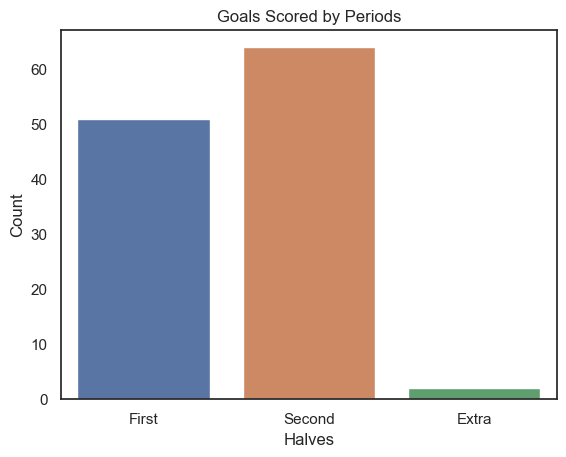

In [11]:
sns.set_theme(style="white")
ax=sns.barplot(x=['First', 'Second', 'Extra'], y=halves.Team)
ax.set_title('Goals Scored by Periods')
ax.set_ylabel('Count')
ax.set_xlabel('Halves');

In [12]:
t=df[['Team','Half']].groupby(['Team','Half']).value_counts().reset_index()

In [13]:
t = t.rename(columns={0:'Count'})

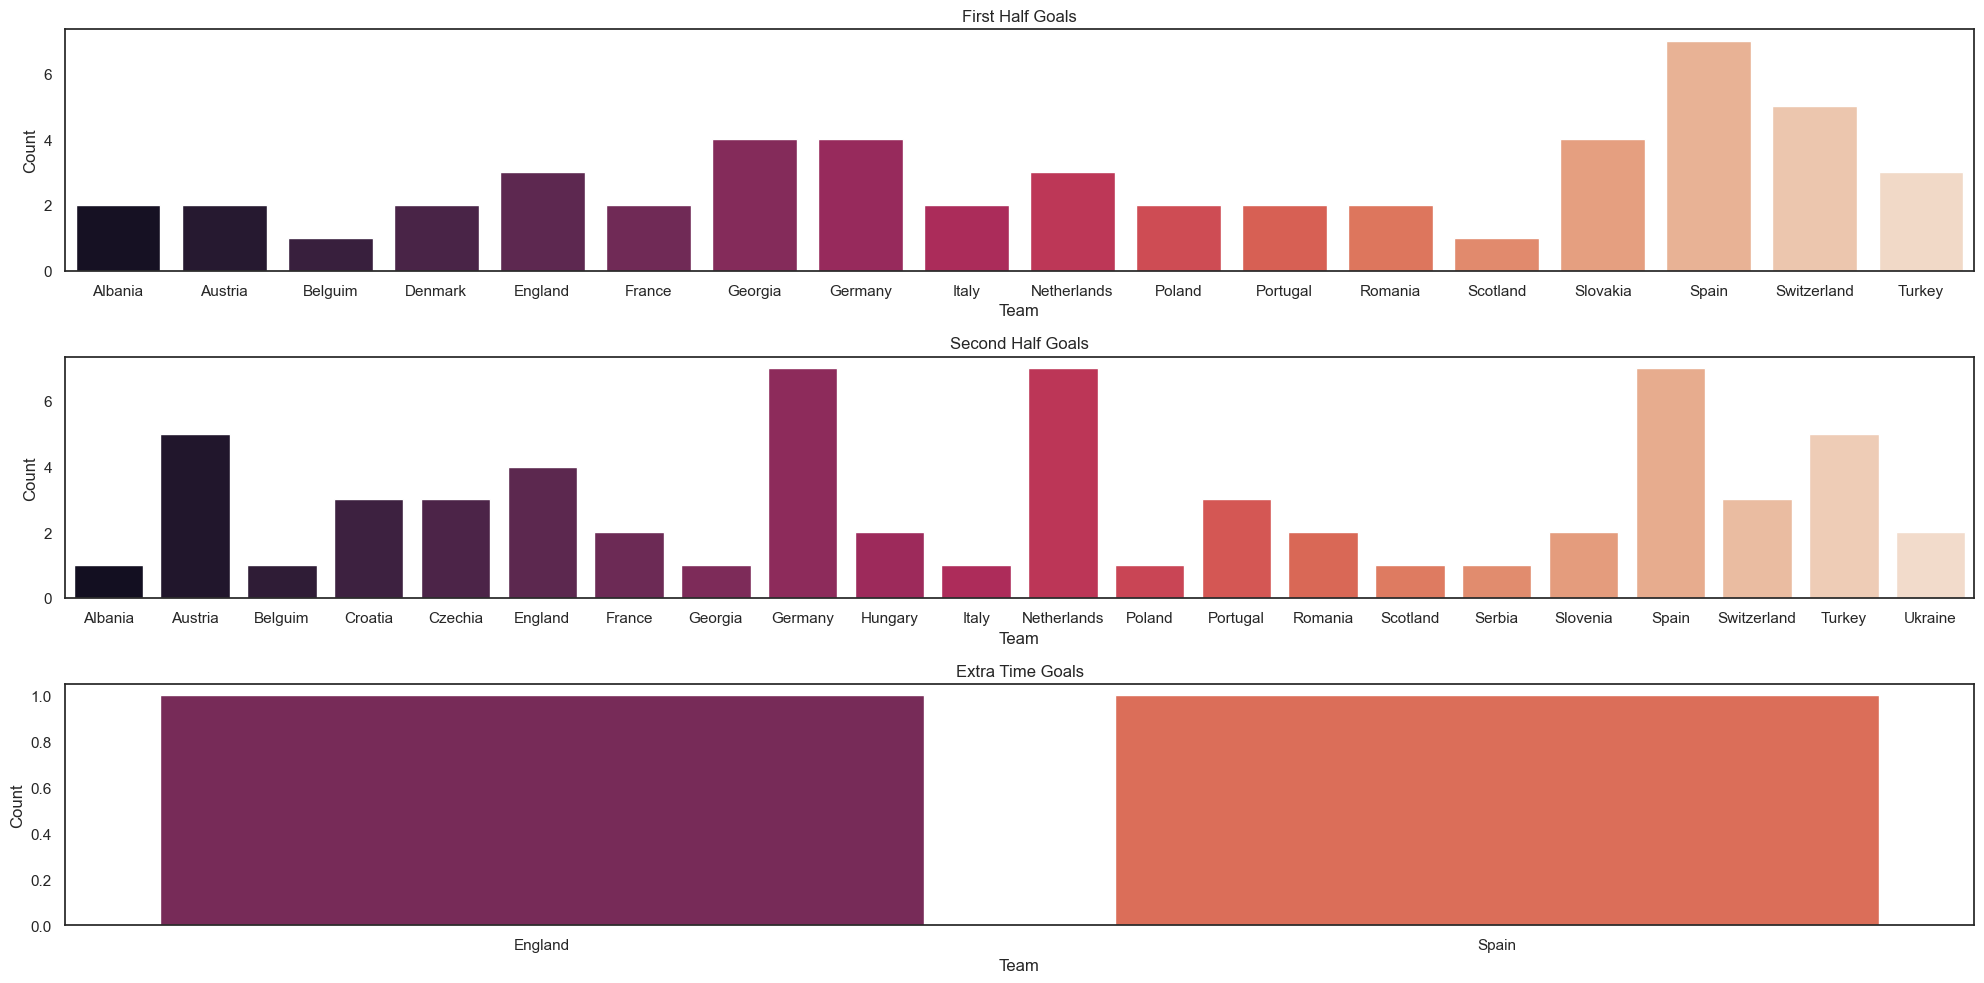

In [14]:
first = t[t['Half']==1]
second = t[t['Half']==2]
extra = t[t['Half']==3]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

sns.barplot(x=first['Team'], y=first['Count'], palette="rocket", ax=ax1)
ax1.set_title('First Half Goals')
ax2.set_title('Second Half Goals')
ax3.set_title('Extra Time Goals')
sns.barplot(x=second['Team'], y=second['Count'], palette="rocket", ax=ax2)
sns.barplot(x=extra['Team'], y=extra['Count'], palette="rocket", ax=ax3)
f.tight_layout();


In [15]:
second

,Team,Half,Count
1,Albania,2,1
3,Austria,2,5
5,Belguim,2,1
6,Croatia,2,3
7,Czechia,2,3
10,England,2,4
13,France,2,2
15,Georgia,2,1
17,Germany,2,7
18,Hungary,2,2


## Average time after a goal for another goal

I want to find the time it takes a team to score a goal AFTER a goal has been scored. I'll be able to use this info for the average.

In [16]:
for i in range(len(df)):
    if df.loc[i,'Aggregate']==1:
        df.loc[i,'Duration']=0
    else:
        df.loc[i, 'Duration'] = df.loc[i, 'Minute']-df.loc[i-1, 'Minute']

In [17]:
print('The average duration between goals is ', df['Duration'].mean(), ' minutes')

The average duration between goals is  15.025641025641026  minutes


Let's do some graphing! 

In [18]:
#Get all the teams (which are in order of how well they did)
teams = df.Team.unique()

#Create a list of the average duration of time after a goal to score
avg_dur = []
for team in teams:
    avg_dur.append(df[df['Team']==team]['Duration'].mean())

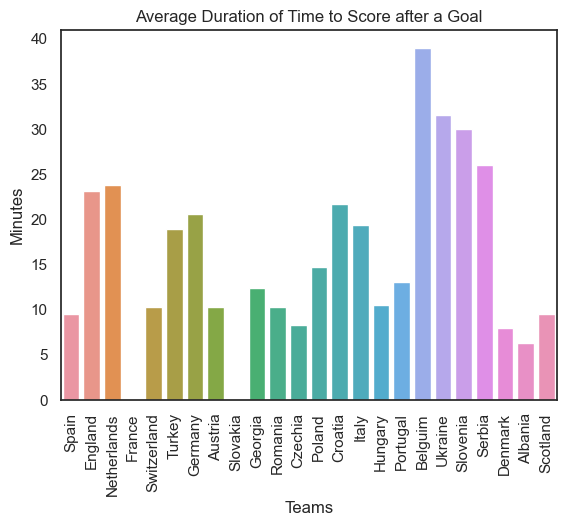

In [19]:
#Plot a bargraph

sns.set_theme(style="white")
ax=sns.barplot(x=teams, y=avg_dur)
ax.set_title('Average Duration of Time to Score after a Goal')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
plt.xticks(rotation=90);

I also want to see the average minute teams scored as well as the total amount of goals scored for each team.

In [20]:
goals_per_team = df['Team'].value_counts()

In [21]:
goals_per_team

Spain          15
Germany        11
Netherlands    10
Switzerland     8
Turkey          8
England         8
Austria         7
Georgia         5
Portugal        5
France          4
Slovakia        4
Romania         4
Italy           3
Albania         3
Poland          3
Croatia         3
Czechia         3
Hungary         2
Belguim         2
Ukraine         2
Slovenia        2
Denmark         2
Scotland        2
Serbia          1
Name: Team, dtype: int64

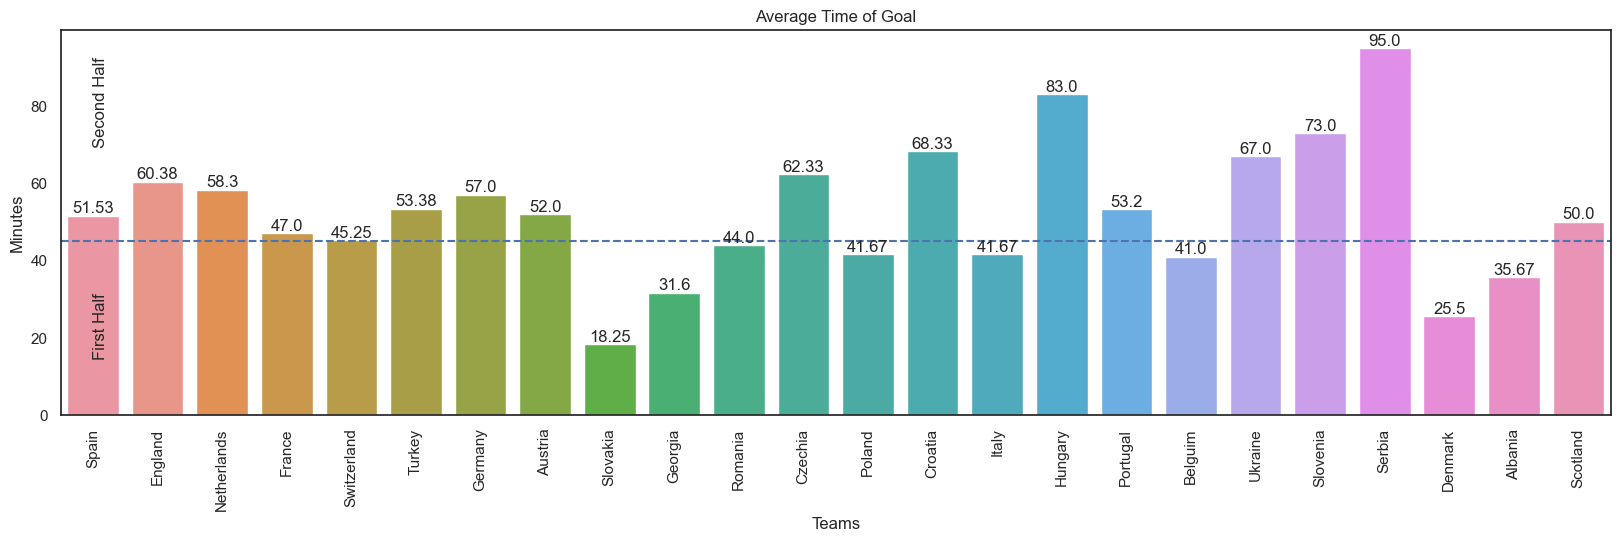

In [22]:
avg_min = []
for team in teams:
    avg_min.append(df[df['Team']==team]['Minute'].mean().round(2))

fig, ax = plt.subplots(1, 1, figsize = (20, 5))
ax=sns.barplot(x=teams, y=avg_min)
ax.set_title('Average Time of Goal')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
ax.axhline(y = 45, linestyle = "dashed")
plt.xticks(rotation=90)
ax.text(0, 15, "First Half", rotation=90)
ax.text(0, 70, "Second Half", rotation=90)
#ax.bar_label(ax.containers[0], labels=goals_per_team)
ax.bar_label(ax.containers[0], labels=avg_min, fmt='%.2f');

In [23]:
nu = df[['Team','Aggregate','Half']].groupby(['Team','Aggregate']).value_counts().reset_index()

In [24]:
for team in teams:
    print(nu[nu['Team']==team])

     Team  Aggregate  Half  0
59  Spain          1     2  3
60  Spain          1     1  2
61  Spain          2     1  3
62  Spain          3     2  2
63  Spain          3     1  2
64  Spain          3     3  1
65  Spain          4     2  1
66  Spain          5     2  1
       Team  Aggregate  Half  0
15  England          1     1  2
16  England          2     2  3
17  England          2     1  1
18  England          3     3  1
19  England          3     2  1
           Team  Aggregate  Half  0
37  Netherlands          1     1  2
38  Netherlands          2     2  3
39  Netherlands          2     1  1
40  Netherlands          3     2  3
41  Netherlands          4     2  1
      Team  Aggregate  Half  0
20  France          1     2  2
21  France          1     1  2
           Team  Aggregate  Half  0
67  Switzerland          1     1  3
68  Switzerland          1     2  1
69  Switzerland          2     1  2
70  Switzerland          2     2  1
71  Switzerland          4     2  1
      Team  A

Of the teams with an average duration of 0, I want to explore France more. My guess is that they scored first every time. 

I will make a subset of just France and see their Aggregate data is all 1s.

In [25]:
france = df[df['Team']=='France'].copy()
france

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes
6,7/9/2024,43,France,1,1,9,0.0,NaN
23,7/1/2024,37,France,1,2,85,0.0,NaN
43,6/25/2024,29,France,1,2,56,0.0,Penalty
94,6/17/2024,8,France,1,1,38,0.0,Own_Goal


In [26]:
slovakia = df[df['Team']=='Slovakia'].copy()
slovakia

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes
24,6/30/2024,36,Slovakia,1,1,25,0.0,NaN
36,6/26/2024,32,Slovakia,1,1,24,0.0,NaN
63,6/21/2024,20,Slovakia,1,1,17,0.0,NaN
93,6/17/2024,9,Slovakia,1,1,7,0.0,NaN


In [27]:
goal_num = df['Aggregate'].unique()

In [28]:
for goal in goal_num:
    print(goal)

1
2
3
4
5
6


In [1]:
sns.histplot(data=df, x='Minute', kde=True, hue='Aggregate', binwidth=15, palette='tab10')
ax.set_title(' Time of Goals for Each Goal Number');

NameError: name 'sns' is not defined

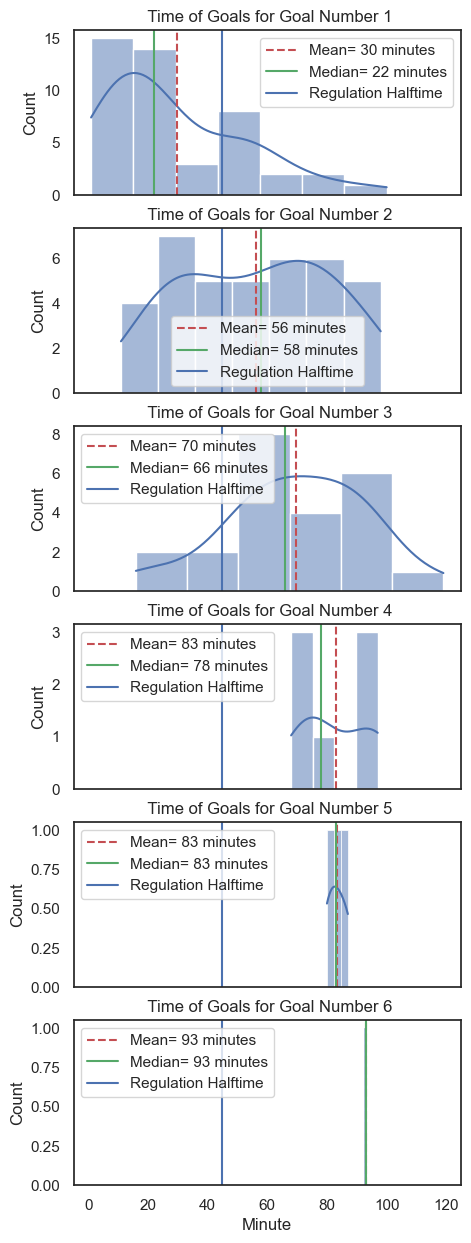

In [30]:
fig, ax = plt.subplots(6, 1, figsize = (5, 15), sharex=True)
for goal in goal_num:
    plt.sca(ax[goal-1])
    sns.histplot(data=df[df['Aggregate']==goal], x=df[df['Aggregate']==goal]['Minute'], kde=True)
    ax[goal-1].set_title(' Time of Goals for Goal Number ' + str(goal))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].mean(), color='r', linestyle='--', 
                       label='Mean= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].mean())))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].median(), color='g', linestyle='-', 
                       label='Median= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].median())))
    ax[goal-1].axvline(x=45, label='Regulation Halftime', color='b', linestyle='-')
    ax[goal-1].legend()
    ;

In [31]:
for goal in goal_num:
    print('There were ' + str(df[df['Aggregate']==goal]['Match_ID'].count()) + 
          ' goals for goal number ' + str(goal))

There were 45 goals for goal number 1
There were 38 goals for goal number 2
There were 23 goals for goal number 3
There were 7 goals for goal number 4
There were 3 goals for goal number 5
There were 1 goals for goal number 6


## Let's create a predictor! 

I'm going to use XGBoost Regressor to try and make a prediction for each goal. I think this is a good place to pause and think about engineering some other variables to make the model more robust. I'm also interested in using Bayesian statistics to create a model after listening to a podcast episdoe on Super Data Podcast.

In [32]:
df.dtypes

Date          object
Match_ID       int64
Team          object
Aggregate      int64
Half           int64
Minute         int64
Duration     float64
Notes         object
dtype: object

I also want to get rid of the first three rows because I want to test on the Spain vs England game

In [33]:
df.Duration.value_counts()

0.0     45
13.0     4
12.0     4
7.0      4
21.0     3
5.0      3
15.0     3
26.0     3
10.0     3
27.0     2
33.0     2
19.0     2
16.0     2
23.0     2
28.0     2
24.0     2
9.0      2
63.0     2
6.0      2
4.0      2
1.0      1
37.0     1
3.0      1
11.0     1
60.0     1
54.0     1
32.0     1
72.0     1
45.0     1
2.0      1
36.0     1
78.0     1
70.0     1
64.0     1
43.0     1
35.0     1
41.0     1
55.0     1
38.0     1
30.0     1
8.0      1
58.0     1
22.0     1
Name: Duration, dtype: int64

In [109]:
X = df.drop(columns='Minute', axis=1)
y = df['Minute'].reset_index()

In [35]:
X = X[3:]

In [110]:
y= y[3:]

In [37]:
X

,Date,Match_ID,Team,Aggregate,Half,Duration,Notes
3,7/10/2024,44,Netherlands,1,1,0.0,NaN
4,7/10/2024,44,England,2,1,11.0,Penalty
5,7/10/2024,44,England,3,2,72.0,NaN
6,7/9/2024,43,France,1,1,0.0,NaN
7,7/9/2024,43,Spain,2,1,12.0,NaN
...,...,...,...,...,...,...,...
112,6/14/2024,1,Germany,2,1,9.0,NaN
113,6/14/2024,1,Germany,3,1,27.0,"Penalty, Stoppage_HT"
114,6/14/2024,1,Germany,4,2,22.0,NaN
115,6/14/2024,1,Scotland,5,2,19.0,Own_Goal


In [38]:
y.drop(columns='index', inplace=True)

In [39]:
X.drop(columns = ['Date', 'Match_ID'], axis=1, inplace=True)

In [40]:
X=pd.get_dummies(X, columns=['Team', 'Aggregate','Half', 'Notes'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4242)

In [45]:
eu = XGBRegressor()

In [46]:
eu.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
y_pred=eu.predict(X_test)

In [51]:
predictions = [round(value) for value in y_pred]

In [52]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE: %f' %(rmse))
               

RMSE: 11.032866


In [55]:
#Going to try and make a Linear Based Learner
DM_train = xgb.DMatrix(data= X_train, label=y_train)
DM_test =  xgb.DMatrix(data= X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 14.203408


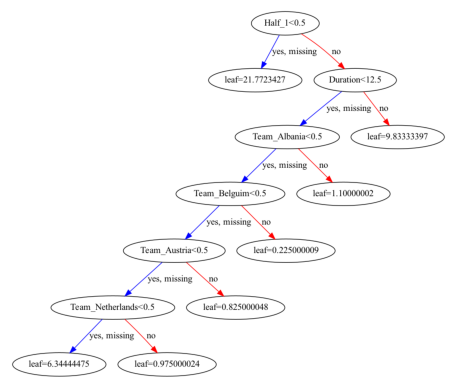

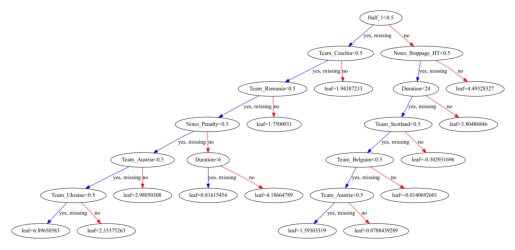

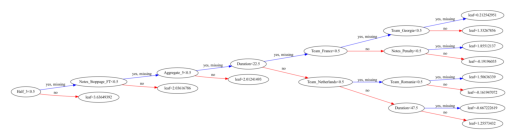

In [56]:
# Plot the first tree
xgb.plot_tree(eu, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(eu, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(eu, num_trees=9, rankdir='LR')
plt.show()

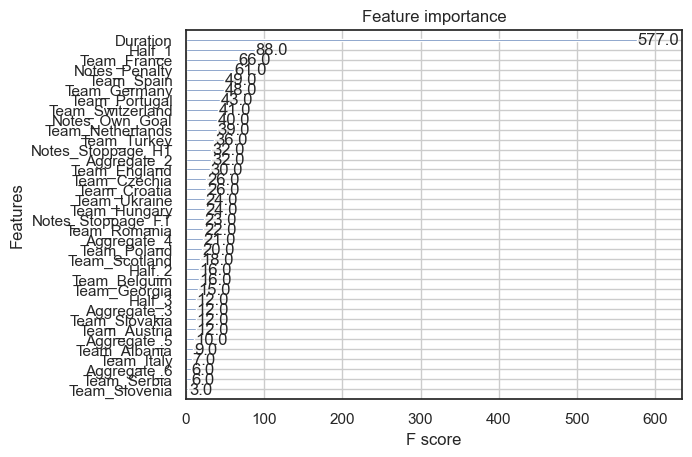

In [57]:
xgb.plot_importance(eu)
plt.show()

In [95]:
y_test_series=y_test.squeeze()

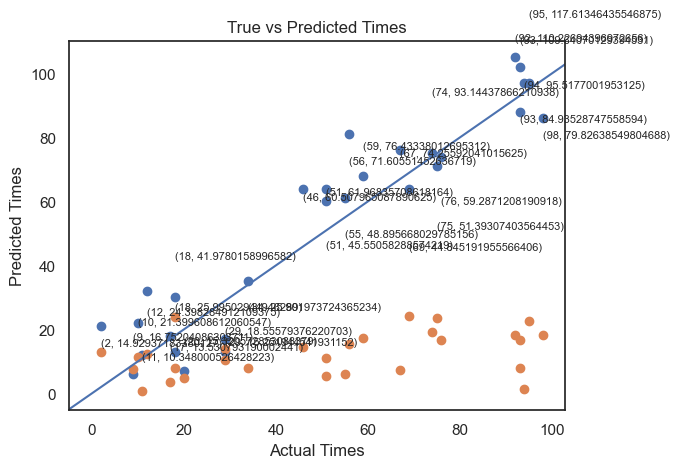

In [98]:
plt.scatter(x=y_test, y=predictions)
plt.scatter(x=y_test, y=abs(y_test_series-preds))
plt.xlabel('Actual Times')
plt.ylabel('Predicted Times')
plt.title('True vs Predicted Times')
plt.axline((0, 0), slope=1)

for x,y in zip(y_test_series, preds):                                     
     plt.text(x, y, f"({x}, {y})", fontsize=8)
plt.show()

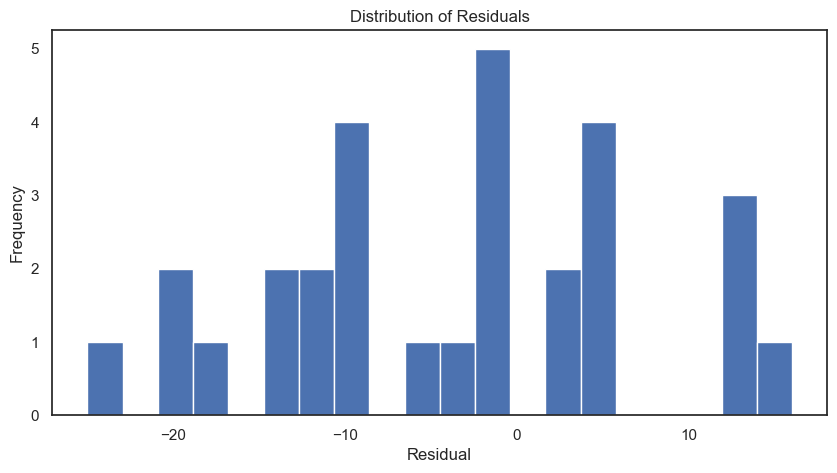

In [100]:
residuals=(y_test_series-predictions)
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [102]:
final_X=X[:3]

In [103]:
final_X

,Duration,Team_Albania,Team_Austria,Team_Belguim,Team_Croatia,Team_Czechia,Team_Denmark,Team_England,Team_France,Team_Georgia,...,Aggregate_5,Aggregate_6,Half_1,Half_2,Half_3,Notes_Own_Goal,Notes_Penalty,"Notes_Penalty, Stoppage_HT",Notes_Stoppage_FT,Notes_Stoppage_HT
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,11.0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
5,72.0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [104]:
final = eu.predict(final_X)

In [105]:
final

array([ 7.0860734, 30.307861 , 89.99812  ], dtype=float32)

Okay going to try something different by creating a pipeline using this tutorial (https://www.youtube.com/watch?v=aLOQD66Sj0g). They use a XGBoost Classifier and I'm using a regression, but we should be able to tweak a few things!  

In [115]:
estimators = [
    ('reg',XGBRegressor(random_state=22))
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=22, ...))])

In [117]:
#Hyperparameter tuning! I changed scoring to 'neg_root_mean_squared_error'

search_space = {
    'reg__max_depth': Integer(2,8),
    'reg__learning_rate': Real(0.001,1.0, prior='log-uniform'),
    'reg__subsample': Real(0.5,1.0),
    'reg__colsample_bytree': Real(0.5,1.0),
    'reg__colsample_byleavel': Real(0.5,1.0),
    'reg__colsample_bynode': Real(0.5,1.0),
    'reg__reg_alpha': Real(0.0,10),
    'reg__reg_lambda': Real(0.0,10),
    'reg__gamma': Real(0.0,10)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring = 'neg_root_mean_squared_error')

In [118]:
opt.fit(X_train, y_train)

[18:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_byleavel" } are not used.

[18:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_byleavel" } are not used.

[18:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_byleavel" } are not used.

[18:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_byleavel" } are not used.

[18:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_byleavel" } are not used.

[18:33:25] WARNING: /Users/runner/work/x

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                             'reg__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'reg__reg_alpha': Real(low=0.0, high=10, prior='uniform', transform='normalize'),
                             'reg__reg_lambda': Real(low=0.0, high=10, prior='uniform', transform='normalize'),
                             'reg__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [119]:
opt.best_estimator_

Pipeline(steps=[('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_byleavel=0.9130048632290858,
                              colsample_bylevel=None,
                              colsample_bynode=0.8182810289168162,
                              colsample_bytree=0.6488529108222634,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=2.5841143475699995,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.21370136639119397, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [120]:
opt.best_score_

-13.327252483044253

In [121]:
opt.score(X_test, y_test)

-11.368082561532248

In [122]:
opt.predict(X_test)

array([ 82.08526 ,  74.94576 ,  18.818628,  18.096605,  65.47933 ,
        22.987074,  19.27801 ,  21.355211,  30.175386,  78.5714  ,
        16.338581,  93.86054 ,  89.42186 ,  92.936104,  94.17277 ,
        62.138462,  11.975457,  77.36475 ,  61.354546,  16.760147,
        68.88176 , 101.14444 ,  63.413017,  32.02495 ,  17.931139,
        16.179335,  71.58622 ,  72.50875 ,  72.93192 ], dtype=float32)

In [123]:
opt.predict(final_X)

array([16.179335, 32.02495 , 87.73308 ], dtype=float32)

In [124]:
opt.best_estimator_.steps

[('reg',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_byleavel=0.9130048632290858, colsample_bylevel=None,
               colsample_bynode=0.8182810289168162,
               colsample_bytree=0.6488529108222634, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=2.5841143475699995, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.21370136639119397, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, ...))]

In [132]:
opt.best_estimator_.steps[0]

'reg'

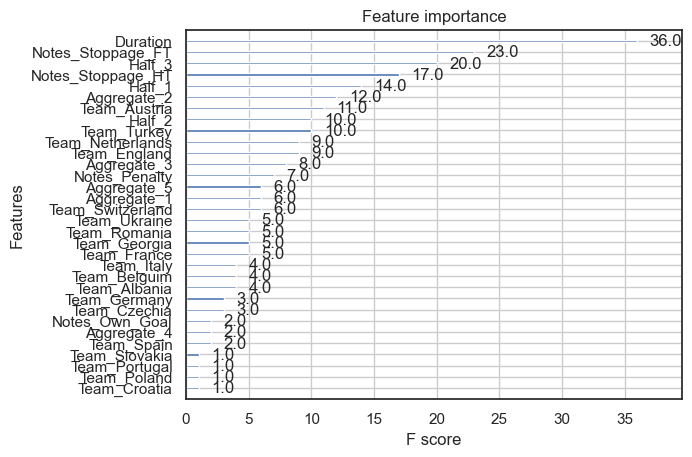

In [135]:
xgb_model = opt.best_estimator_.named_steps['reg']

# Plot feature importance
plot_importance(xgb_model)
plt.show()